In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
def create_graph(df) -> dict:
    """
    returns a didct with keys = node key, and values = edges (node_id, edge weight) 
    """
    tree = {}
    for _, row in df.iterrows():
        parent = row['Parent']
        child = row['Child']
        weight = row['t']

        # root node
        if pd.isna(parent): 
            continue
        # node already exists
        elif parent in tree: 
            tree[parent].append((child, weight))
        # node does not exists
        else:
            tree[parent] = [(child, weight)]
    return tree


def pd_z0():
    return max(np.random.normal(alpha_0, np.sqrt(variance_0)), 1)


def cpd(z, t):
    mean = gamma_0 + (alpha * t) + (beta * z) + (gamma * t * z)
    var = variance * t
    return max(np.random.normal(mean, np.sqrt(var)), 1)


def simulation(root: int, graph: dict, alpha0, variance0, alpha, beta, variance) -> dict:
    """
    BFS
    returns z value for all 407 nodes
    """
    gene_lengths = {}
    
    z0 = max(np.random.normal(alpha0, np.sqrt(variance0)), 1)
    queue = [(root, z0)]

    while queue:
        # handle the next element in queue
        node, z = queue.pop(0)
        
        # set node in results in genelength z
        gene_lengths[node] = z
        
        # get all children for the node
        children = graph.get(node, [])

        if not children:
            continue
        else:
            # for all the children for this node calculate their z
            # since we know it's a tree, only the parent can have influence
            for child in children:
                id, t = child
                t = round(t, 3)
                
                # draw a sample
                mean = (alpha * t) + (beta * z)
                var = variance * t
                
                    
                cpd_z = max(np.random.normal(mean, np.sqrt(var)), 1)
                #print(f"id:{id}, t:{t}, var:{var}, std:{np.sqrt(var)}, mean:{mean}, cpd:{cpd_z}")
                #if id == 205:
                #    print(var)
                #    print(mean)
                #    print(cpd_z)
                # append child to queue
                queue.append((id, cpd_z))

    return gene_lengths


def n_simulations(n, root, graph, alpha0, variance0, alpha, beta, variance) -> tuple:
    """
    Returns results for X=X1 ... X204 n times, and y=Z0 n times s
    """
    X = np.empty((n, 204))
    Z = np.empty((n, 203))
    y = np.empty(n)
    
    for i in range(n):
        results = simulation(root=root, graph=graph, alpha0=alpha0[i], variance0=variance0[i], alpha=alpha[i], beta=beta[i], variance=variance[i])
        
        # extract the first 204 values from the dictionary and add them to X as a row
        row_X = [results[key] for key in range(1, 205)]
        row_Z = [results[key] for key in range(205, 408)]
        
        X[i] = np.array(row_X)
        Z[i] = np.array(row_Z)
        
        
    return X, Z



def dfs_paths_with_cpd(graph, start_node, z, path=None):
    # returns all paths and the gene length at each node in the path
    if path is None:
        path = [(start_node, z)]

    if start_node not in graph:
        return [path]

    paths = []
    for child, t in graph[start_node]:
        if child not in [node for node, _ in path]:
            new_z = cpd(z, t)
            child_paths = dfs_paths_with_cpd(graph, child, new_z, path + [(child, new_z)])
            paths.extend(child_paths)

    return paths

In [4]:
# load data
tree_data = pd.read_csv('data/tree.csv')
genes_data = pd.read_csv('data/vert_genes.csv')

# remove root node, since we already have reference to it from else where. unless issue with t?
tree_data = tree_data[tree_data['Parent'].notna()]

# convert parent col to ints
tree_data['Parent'] = tree_data['Parent'].astype(int)

In [5]:
# gamma_0 + (alpha * time) (beta * parent gene len) + (gamma * time * parent gene len)

# Parameters
# for Z_0
size = 5000
alpha0 = np.random.normal(50000, 50, size=size)
variance0 = np.random.normal(5000, 10, size=size)

# for Z_i and X_i
alpha = np.random.normal(0, 0.5, size=size)
beta = np.random.normal(3, 1, size=size)
variance = np.random.normal(2500, 10, size=size)

# Settings
root = 407

# create a dict graphe
graph = create_graph(tree_data)

In [6]:
print(alpha0.shape)
print(variance)
np.min(variance),np.max(variance),np.mean(variance),np.var(variance)

(5000,)
[2511.44687813 2499.53737569 2484.61954341 ... 2502.58904078 2495.82943144
 2522.2536109 ]


(2466.4212260547683, 2540.092810975566, 2499.998063201221, 98.81662692489152)

In [7]:
# Create data
t0 = time.time()

X, Z = n_simulations(size, root, graph, alpha0, variance0, alpha, beta, variance)
runtime = time.time() - t0
print(f"{runtime:.10f} sec")

9.6907882690 sec


In [8]:
V = np.concatenate((X,Z),axis=1)
print(V)
#V = np.concatenate(X,Z,alpha0,variance0,alpha,beta,variance)

[[2.21457374e+10 2.21457376e+10 1.07556259e+10 ... 7.83560372e+06
  3.80552346e+06 5.00625114e+04]
 [3.56647000e+15 3.56647000e+15 8.89706650e+14 ... 8.31192362e+08
  2.07352848e+08 4.99338300e+04]
 [5.07615696e+10 5.07615695e+10 2.35411088e+10 ... 1.08451031e+07
  5.02948756e+06 4.99399819e+04]
 ...
 [3.46035761e+08 3.46035723e+08 2.11684929e+08 ... 1.55362101e+06
  9.50352469e+05 4.99550113e+04]
 [4.65194438e+12 4.65194438e+12 1.67855740e+12 ... 6.27184727e+07
  2.26306890e+07 5.00053654e+04]
 [1.28672132e+10 1.28672130e+10 6.43964111e+09 ... 6.36361856e+06
  3.18480330e+06 4.99869542e+04]]


In [9]:
# lin r
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regAlpha = LinearRegression().fit(V, alpha)
regBeta = LinearRegression().fit(V, beta)
regSigma = LinearRegression().fit(V, variance)

# Train results
yt_pred = regAlpha.predict(V)
train_r2 = regAlpha.score(V, alpha)
train_mse = mean_squared_error(alpha, yt_pred)

yt_pred1 = regBeta.predict(V)
yt_pred2 = regSigma.predict(V)
'''# Test results
y_pred = reg.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)'''

print(f"TRAIN. r2: {train_r2:.3f}, MSE: {train_mse:.3f}")
#print(f"TEST. r2: {test_r2:.3f}, MSE: {test_mse:.3f}")

TRAIN. r2: -0.017, MSE: 0.248


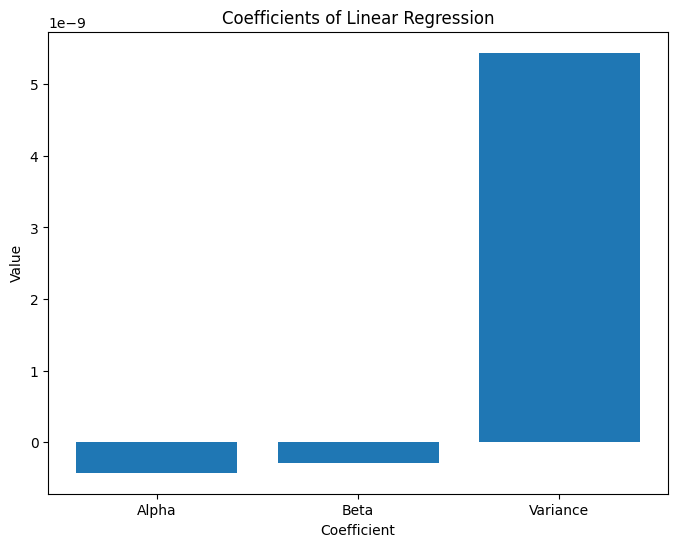

In [14]:
import matplotlib.pyplot as plt

# Get the coefficients
alpha_coef = regAlpha.coef_
beta_coef = regBeta.coef_
sigma_coef = regSigma.coef_

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['Alpha', 'Beta', 'Variance'], [alpha_coef[0], beta_coef[0], sigma_coef[0]])
plt.title('Coefficients of Linear Regression')
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.show()


In [13]:
alpha_coef = regAlpha.coef_
beta_coef = regBeta.coef_
sigma_coef = regSigma.coef_

#printing coefficients
print("Alpha Coefficients: ", alpha_coef)
print("Beta Coefficients: ", beta_coef)
print("Variance Coefficients: ", sigma_coef)

Alpha Coefficients:  [-4.28078776e-10  4.35402217e-10 -1.29325811e-10 -4.86958266e-11
  9.91601973e-11  1.78734898e-10  1.78277584e-10  9.55913577e-11
 -1.56809943e-11  9.54571179e-11  9.54529881e-11  1.77832107e-10
  1.77933622e-10  9.51714337e-11 -1.25871168e-10  3.61948137e-11
 -3.90268558e-11  1.25213052e-10  1.02158438e-11 -5.45120098e-11
 -5.44983013e-11 -5.44833394e-11 -1.63789721e-10 -1.63772360e-10
 -2.18039320e-10 -5.67610523e-11  1.12134566e-10 -4.10192166e-11
 -4.10376951e-11 -1.59364384e-10  2.57121366e-10 -4.13176831e-11
 -4.16271202e-11 -1.59955931e-10  2.57038348e-10  2.56931288e-10
  2.56924847e-10  3.08316061e-11  3.11191025e-11 -7.17860408e-11
 -7.17952603e-11  3.05388520e-11 -1.60334848e-10  2.56956867e-10
 -2.17506553e-10 -2.17508078e-10 -5.66299338e-11 -5.53574250e-11
 -5.53509030e-11 -2.10359567e-10 -2.10351453e-10 -5.53661304e-11
  1.87612410e-10 -5.80189424e-11 -5.80277464e-11 -2.23814360e-10
 -2.23814372e-10 -5.80477864e-11  1.87503821e-10  1.81915241e-10
  9.

ValueError: x and y must be the same size

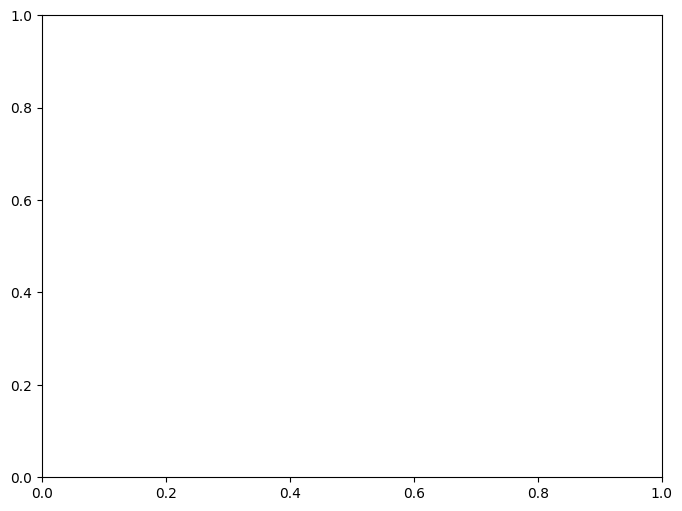

In [11]:
import numpy as np

# Get the coefficients
alpha_coef = regAlpha.coef_
beta_coef = regBeta.coef_
sigma_coef = regSigma.coef_

# Create a scatter plot
plt.figure(figsize=(8, 6))
x = np.arange(3)
plt.scatter(x, alpha_coef, label='Alpha')
plt.scatter(x, beta_coef, label='Beta')
plt.scatter(x, sigma_coef, label='Variance')
plt.xticks(x, ['Intercept', 'X1', 'X2'])
plt.title('Coefficients of Linear Regression')
plt.xlabel('Coefficient')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
print(yt_pred)
print(alpha)

print(regBeta.score(V,beta))
print(regSigma.score(V,variance))
print((yt_pred1-beta))
print((yt_pred2,variance))
print(np.min(yt_pred2))
print(np.min(variance))

[ 0.0043155  -0.01959604  0.01114266 ...  0.0026513  -0.00252054
 -0.00148036]
[-0.0987917  -0.33863532 -0.49135237 ...  0.66877973  0.15390939
  1.05729465]
0.9054314112925632
0.004374907558999719
[-0.06076161 -0.19112354  0.23316474 ... -0.04686099  0.09508501
  0.04230185]
(array([2499.84524855, 2500.3631297 , 2500.20747693, ..., 2499.76313883,
       2499.54257903, 2499.57524023]), array([2507.95599739, 2496.55227645, 2494.44576974, ..., 2512.51185711,
       2500.81716903, 2502.6206323 ]))
2486.3828413449646
2463.2606656378653
